# Climate Coding Challenge

Climate change is impacting the way people live around the world

Overview

Higher highs, lower lows, storms, and smoke – we’re all feeling the
effects of climate change. In this workflow, I took a look at
trends in temperature over time in New York City, NY.

I grew up in the suburbs of New York City, and major weather events that hit the city either also hit my hometown directly or was prominent local news. Recently, lots of rain over the summers has led to significant flooding of homes, apartments, and the subway system. Both in New York and in Colorado, the large wildfires in Canada have impacted air quality over the past several summers.

## Wrangle Data

In [2]:
# Import libraries
import earthpy # Manage local data
import pandas as pd # Import pandas package under shortname pd
pip install nbconvert

SyntaxError: invalid syntax (1372847515.py, line 4)

In [2]:
%store -r nyc_climate_df

In [3]:
# Set up project folders
project = earthpy.Project(
    'New York City Climate',
    dirname='/workspaces/02-climate-mirich42-portfolio')

# Check where the data ended up
project.project_dir

PosixPath('/workspaces/02-climate-mirich42-portfolio')

## Where did this data come from?
The following dataset was downloaded from the National Centers for Environmental Information (NCEI) website. The data is from a station located in Central Park, New York City, NY. I pulled the "Max daily temperature" data, as there were no average or temperature at time of observation measurements. Daily maxima seemed more interesting to plot than daily minima.

In [4]:
# Load climate data from NCEI
nyc_climate_df_raw = pd.read_csv(
    project.project_dir / 'ncei-climate-nyc.csv', 
    index_col = 'DATE', 
    parse_dates = True, 
    na_values = ['NAN']
)

In [5]:
nyc_climate_df = nyc_climate_df_raw[["TMAX"]]
nyc_climate_df
type(nyc_climate_df)

pandas.core.frame.DataFrame

# Convert units

It’s important to keep track of the units of all your data. You don’t
want to be like the [NASA team who crashed a probe into Mars because
different teams used different
units](https://www.latimes.com/archives/la-xpm-1999-oct-01-mn-17288-story.html))

In [6]:
# Change the column header of TOBS (observed temperature) to temp_f 
# (slightly more descriptive, includes units)
nyc_climate_df = nyc_climate_df.rename(columns={
    'TMAX': 'temp_f',
})

In [7]:
# Convert units (farenheit to celsius) with a function
def convert(temperature_f_to_c):
    """Convert Fahrenheit temperature to Celcius"""
    return  (temperature_f_to_c - 32) * (5/9)

# Run the conversion function to add a column with temperature in celsius
nyc_climate_df['temp_c'] = (
    nyc_climate_df['temp_f'].apply(convert))

## Plotting!
Let's take a look at the data by making some plots of daily and annual averages of our maximum recorded temperatures.

<Axes: title={'center': 'Daily Maximum Air Temperature in New York City, NY (1925-2025)'}, xlabel='Year', ylabel='Temperature (farenheit)'>

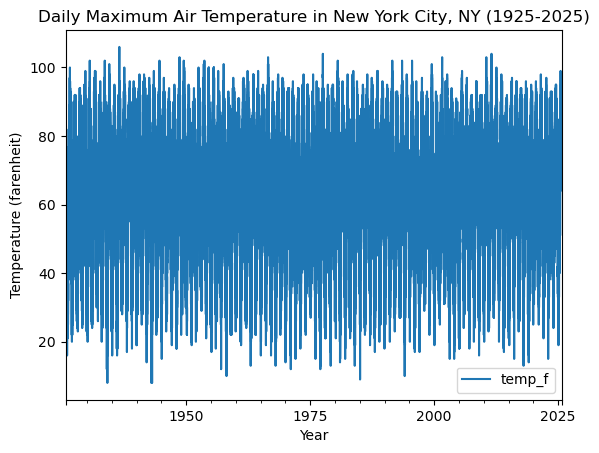

In [8]:
# Plot the data using .plot
nyc_climate_df.plot(
    # Data
    y='temp_f',

    # Formatting
    title='Daily Maximum Air Temperature in New York City, NY (1925-2025)',
    xlabel='Year',
    ylabel='Temperature (farenheit)')

## Clean up timeseries by resampling
We now would like to look at trends in annual averages - it is hard to understand what is going on when looking at the daily temperature plot above.

In [9]:
# Resample climate data for annual averages
ann_nyc_climate_df = (
    # Resample starting at the beginning of the year and calculate the annual average
    nyc_climate_df.resample('YS').mean())

<Axes: title={'center': 'Annual Maximum Air Temperature in New York, NY (1925-2025)'}, xlabel='Year', ylabel='Temperature (farenheit)'>

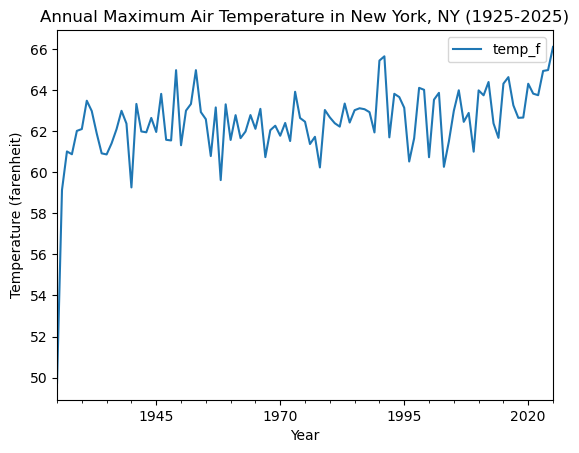

In [10]:
# Plot the annual data
ann_nyc_climate_df.plot(
    # Data
    y='temp_f',

    # Formatting
    title='Annual Maximum Air Temperature in New York, NY (1925-2025)',
    xlabel='Year',
    ylabel='Temperature (farenheit)')

## Check out the data with an interactive plot
Zoom in, click on values - this is an easy way to explore this dataset!

In [11]:
# First import hvplot
import hvplot.pandas

# Plot the annual data interactively
annual_interactive = ann_nyc_climate_df.hvplot(
    # Data
    y='temp_f',

    # Formatting
    title='Annual Maximum Air Temperature in New York City, NY (1925-2025)',
    xlabel='Year',
    ylabel='Temperature (farenheit)')

# Generate the plot
annual_interactive

:Curve   [DATE]   (temp_f)

Overall minimum and maximum temps?

In [12]:
# Download interactive plot
import holoviews as hv
hv.save(annual_interactive, 'nyc_climate_annual_interactive_plot.html')

# Analyze Trends
Let's fit an an OLS linear regression to the data and see what sort of trend it sees. 

Is it appropriate to use an OLS linear regression? Are the criteria for random error, randomly distributed error, linearity, and stationarity met?

It would be unfair to assume that all of the variation in temperature, except for climate change, is random. Larger global patterns can influence temperatures on a variety of timescales (I think the ENSO operates on 3-5 year timescales, for example, and there are other general trends that may push the temperatures higher or lower in any sequence of years). Because we are looking at annual trends in temperature, I would guess that we have fairly normally distributed error. I would imagine that assuming linearity is fair in this climate, since there is not a lot of ice or water to dampen the effects of air temperature change. I think that assuming stationarity does get a litle dicey, because (as the text mentions), climate change tends to cause increased variability in both directions. Overall, the OLS regression works well enough for a quick look at this data, but it is important to acknowledge where its weaknesses lie.

In [13]:
# Advanced options on matplotlib/seaborn/pandas plots
import matplotlib.pyplot as plt
# Common statistical plots for tabular data
import seaborn as sns
# Fit an OLS linear regression
from sklearn.linear_model import LinearRegression

In [14]:
# Fit an OLS Linear Regression to the data

# If index is datetime, extract the year as an integer column
ann_nyc_climate_df['year'] = ann_nyc_climate_df.index.year

# Remove "na" values so the model can run
df_clean = ann_nyc_climate_df[['year', 'temp_f']].dropna()

# Define x and y variables for the model
X = df_clean['year'].values.reshape(-1, 1)
y = df_clean['temp_f'].values

# Run the linear regression model
model = LinearRegression()
model.fit(X, y)

# Add the results of the model to a new column called "fitted"
df_clean['fitted'] = model.predict(X)

# Find slope and intercept values
slope = model.coef_[0]
intercept = model.intercept_

# Print the equation for the linear regression
print(f"Equation: temp_f = {intercept:.2f} + {slope:.4f} * year")

Equation: temp_f = 9.26 + 0.0269 * year


<Axes: title={'center': 'Annual Average Maximum Air Temperatures in New York City, NY 1925-2025'}, xlabel='Year', ylabel='Air Temperature (farenheit)'>

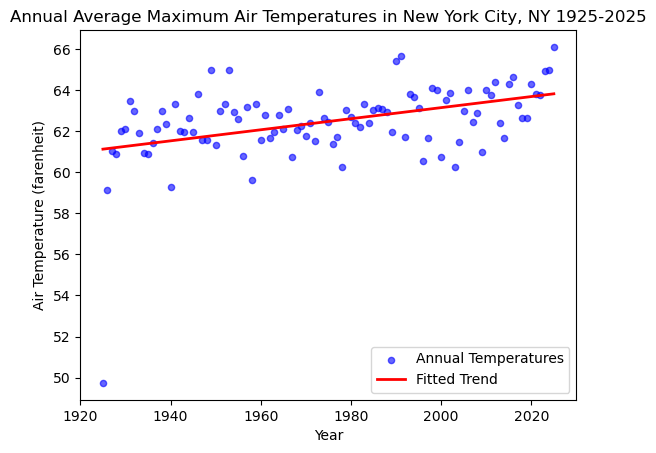

In [15]:
# Plot a trend line on top of annual average temperatures

# Create a scatter plot with the annual average temperatures
ax = df_clean.plot.scatter(
    # Data
    x='year', 
    y='temp_f',

    # Formatting and Labels
    alpha=0.6, # opacity of plotted points
    color='blue', # color of plot
    label='Annual Temperatures', # Label for the data
    title='Annual Average Maximum Air Temperatures in New York City, NY 1925-2025', # Add title

    ylabel='Air Temperature (farenheit)'# Y axis label
)

# Create a plot with the trendline, to overlay on top of the annual average plot
df_clean.plot.line(
    # Data
    x='year', 
    y='fitted',

    # Formatting
    color='red', # Trendline color
    linewidth=2,  # Trendline width
    label='Fitted Trend', # Trendline label
    xlabel='Year', # X axis label
    ax=ax  # overlay on the same axes
)

My plot shows that average annual maximum temperatures are trending upwards, at a rate of 0.0269 degrees Farenheit per year. Additional statistical testing will need to be done to make any conclusions on the significance of this trend line. Looking at the values themselves, it looks like at around the year 1930, the annual average maximum temperature was just under 62 degrees Farenheit, and now it is just around 63 degrees Farenheit. Again, without statistical tests I cannot conclude whether that increase is statistically significant or could be random, but it does not seem to be that great of an increase. What taking annual averages does remove from the conversation are instances of high temperature spikes or heat waves, which have more of an immediate impact on human health and quality of life in the city (for example, instances of heat stroke and power outages) (Dutta et al., 2025). To look at the change in maximum temperatures over time, we would not plot the annual averages, but the annual maxima. Next time!

# Citations

Maya Dutta, Pablo Herreros-Cantis, Timon McPhearson, Ahmed Mustafa, Matthew I. Palmer, Mika Tosca, Jennifer Ventrella, Elizabeth M. Cook,New York City 2100: Environmental justice implications of future scenarios for addressing extreme heat,
Landscape and Urban Planning, Volume 254, 2025, 105249, ISSN 0169-2046, https://doi.org/10.1016/j.landurbplan.2024.105249.

Menne, Matthew J., Imke Durre, Bryant Korzeniewski, Shelley McNeill, Kristy Thomas, Xungang Yin, Steven Anthony, Ron Ray, Russell S. Vose, Byron E.Gleason, and Tamara G. Houston (2012): Global Historical Climatology Network - Daily (GHCN-Daily), Version 3. []. NOAA National Climatic Data Center. doi:10.7289/V5D21VHZ [9/30/2025].